# Data Ingestion

We just need to download the dataset from kaggle. It is large, 45 GB, so it will take some time and also you may need to store it in a seperate location. For my case, I have an external storage so the below function will allow you to define that and download the data there.

The data comes from here: https://www.kaggle.com/datasets/nih-chest-xrays/data.

Also note you need the kaggle api to download the dataset, but to make sure it works you'll have to get an api key from your account. Once you do, you'll get a json file which you need to place in the appropiate location (should look something like `C:\Users\User\.kaggle\kaggle.json`). See the docs for more details: https://github.com/Kaggle/kaggle-api/tree/main.

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import load_dotenv, find_dotenv

In [2]:
def download_kaggle_dataset(dataset_identifier, download_path):
    # Load environment variables from the .env file
    load_dotenv(find_dotenv())

    # Set Kaggle API credentials from environment variables
    os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
    os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

    # Authenticate using Kaggle API
    api = KaggleApi()
    api.authenticate()

    # Make sure the download path exists
    if not os.path.exists(download_path):
        os.makedirs(download_path)

    api.dataset_download_files(dataset_identifier, path=download_path, unzip=True)

This will download the data locally, but we should also download it to a cloud storage of your choice. We will use AWS.

## S3

# Data Exploration

## Independent Variables

Now let's load the data from the downloaded zip file. First let's explore the data from it's tabular form, where we have the image file names with their respective labels alongside a few other columns like age and gender. It contains information from all the folders so we can explore it as a whole, though for the first draft of the model we may train on only one folder (essentially a subset of the data) to simplify the process and training time.

In [3]:
import pandas as pd

data = pd.read_csv('D:\BigData\Data_Entry_2017.csv')

print(data.shape)
data.head()

(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


The only columns that are relevant to use here are the Follow-up #, Patient Age, Patient Gender and View Position.

### Gender

In [4]:
print("Number of unique values for gender:\n\n", data["Patient Gender"].value_counts())
print("\n")
print("Number of null values for gender:", data["Patient Gender"].isnull().sum())

Number of unique values for gender:

 Patient Gender
M    63340
F    48780
Name: count, dtype: int64


Number of null values for gender: 0


So gender is just a binary variable with no null values. This is fine, let's check the age distribution next.

### Age

In [5]:
data["Patient Age"].value_counts()

Patient Age
58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
151       1
411       1
413       1
153       1
154       1
Name: count, Length: 107, dtype: int64

Looks like most people are in the 50s but we have some ages over 200 which is not possible. In fact, the oldest someone has ever lived is 122, so let's see how many points we have that are over 120.

In [6]:
print("Number of people over 120 years old:", data[data["Patient Age"] > 120].shape[0])
print("Number of null values for age:", data["Patient Age"].isnull().sum())

Number of people over 120 years old: 16
Number of null values for age: 0


So looks like there's only 16 people with non-sensical ages, and no null values. We can probably just remove these data points from the dataset then. Let's look at the distribution of the ages.

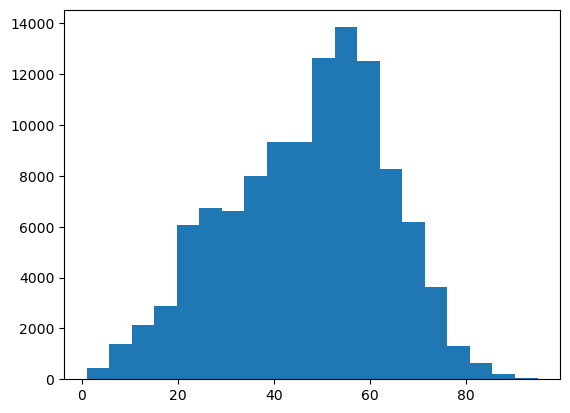

In [32]:
import matplotlib.pyplot as plt

realistic_ages = data[data["Patient Age"] < 120]
plt.hist(realistic_ages["Patient Age"], bins=20)
plt.show()

Looks relatively normally distributed, centered around people in their late 50s. This is fine, we can move on to the View Position column.

### View Position

In [11]:
print("Number of unique values for View Position:\n\n", data["View Position"].value_counts())
print("\n")
print("Number of null values for View Position:", data["View Position"].isnull().sum())

Number of unique values for View Position:

 View Position
PA    67310
AP    44810
Name: count, dtype: int64


Number of null values for View Position: 0


So PA here stands for posterioranterior and is an X-ray with patient facing machine, while AP stands for anteriorposterior and occurs when a patient's back is toward the machine. Looks like this column is the same as gender in that there are no null values, it is a binary variable, and with an almost 50:50 ratio. This is fine, let's take a look at the final column, Follow-up #.

### Follow-up Number

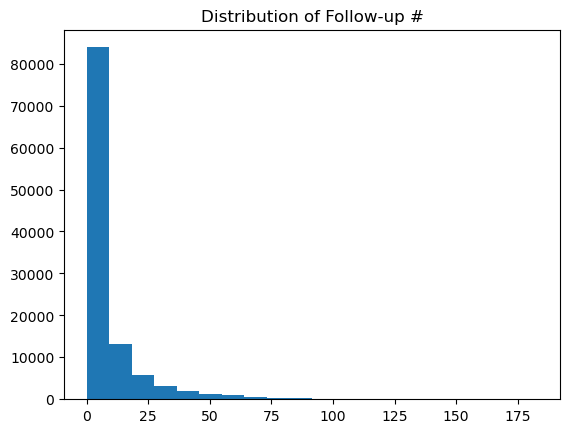

In [23]:
follow_up = data["Follow-up #"]

plt.hist(follow_up, bins=20)
plt.title("Distribution of Follow-up #")
plt.show()

Some people have a lot of follow ups. Presumably people with a lot of follow ups are older folks who have had a lot of x-rays. Or the data is faulty, let's explore. Remember to use realistic ages to filter out the faulty data.

In [34]:
# looks like most of the high follow up values are above 80
high_follow_up = realistic_ages[realistic_ages["Follow-up #"] > 80]
high_follow_up.shape[0]

942

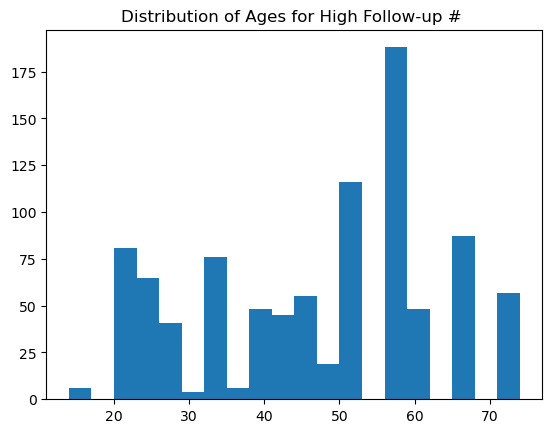

In [35]:
high_follow_up_ages = high_follow_up["Patient Age"]
plt.hist(high_follow_up_ages, bins=20)
plt.title("Distribution of Ages for High Follow-up # ")
plt.show()

Distribution for ages is random amongst these high follow up numbers. You can see for the rest of the data the normal distribution remains.

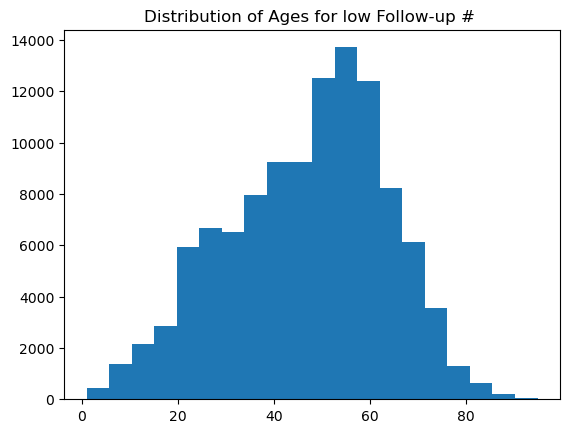

In [33]:
low_follow_up = realistic_ages[realistic_ages["Follow-up #"] <= 80]
low_follow_up_ages = low_follow_up["Patient Age"]
plt.hist(low_follow_up_ages, bins=20)
plt.title("Distribution of Ages for low Follow-up # ")
plt.show()

In [37]:
print(f"Percentage of data with high follow up: {942/data.shape[0] *100}%.")

Percentage of data with high follow up: 0.8401712450945416%.


Ultimately it's less than 1 percent of the data, and it still may be of relevance, as data with a lot of follow up numbers indicate frequent x-rays which indicate recurring or chronic diseases. Let's just leave it for now.

This, the only thing to remove is the ages over 120, which we have here.

In [44]:
realistic_ages.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


In [45]:
cleaned_df = realistic_ages.copy()
cleaned_df = realistic_ages[["Image Index", "Finding Labels", "Follow-up #", "Patient Age", "Patient Gender", "View Position"]]
cleaned_df.shape

(112104, 6)

In [46]:
cleaned_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,58,M,PA


## Target Variable

So the Finding Labels is the target variable and is technically multivariable. Let's explore it and see value counts for each label to see what problem is viable.

First let's check for nulls.

In [60]:
labels = cleaned_df["Finding Labels"]
labels.isnull().sum()

0

Okay so no nulls, now let's split the labels by the pipe symbol and create lists of labels.

In [54]:
labels = cleaned_df["Finding Labels"]

def split_label(label):
    return label.split("|")

split_labels = []

for label in labels:
    if "|" in label:
        split_labels.append(split_label(label))
    else:
        split_labels.append([label])
        
split_labels[:8]

[['Cardiomegaly'],
 ['Cardiomegaly', 'Emphysema'],
 ['Cardiomegaly', 'Effusion'],
 ['No Finding'],
 ['Hernia'],
 ['Hernia'],
 ['Hernia'],
 ['Hernia', 'Infiltration']]

Now let's get the value counts for each label.

In [57]:
from collections import Counter

flattened_labels = [label for sublist in split_labels for label in sublist]
Counter(flattened_labels)

Counter({'No Finding': 60353,
         'Infiltration': 19891,
         'Effusion': 13316,
         'Atelectasis': 11558,
         'Nodule': 6331,
         'Mass': 5779,
         'Pneumothorax': 5301,
         'Consolidation': 4667,
         'Pleural_Thickening': 3384,
         'Cardiomegaly': 2776,
         'Emphysema': 2516,
         'Edema': 2302,
         'Fibrosis': 1686,
         'Pneumonia': 1430,
         'Hernia': 227})

So we have 15 different labels as expected, and only one has a really low value count - being the Hernia label. An easy route to take here, since No Finding is the most common label, we can build two models, one for detecting disease or no disease, and one for detecting which disease (given that a disease is present). Naturally, let's start with the binary model.

Here let's just make sure the No Finding label has only one label in the list (of course, if no disease is present, and there is another label, that would be a contradiction, and thus faulty data).

In [63]:
for i, label_list in enumerate(split_labels):
    if 'No Finding' in label_list and len(label_list) > 1:
        print(i, label_list)

Output is empty, so we're fine here.

# Detecting Disease or No Disease

So this is a binary classification model so let's modify the target variable. 0 will be the label for no disease (originally 'No Finding'), and 1 will be the label for one or more diseases being present.

In [99]:
# let's fix the lack of namign convenstion in the column names
cleaned_df.columns = cleaned_df.columns.str.lower().str.replace(' ', '_')

In [101]:
y = cleaned_df["finding_labels"]
y = y.apply(lambda x: 0 if x=="No Finding" else 1)
y.value_counts()

finding_labels
0    60353
1    51751
Name: count, dtype: int64

Now let's pre-process X, which in this case just means let's convery binary columns to 0 and 1.

In [102]:
X = cleaned_df.drop("finding_labels", axis=1)
X.head(3)

,image_index,follow-up_#,patient_age,patient_gender,view_position
0,00000001_000.png,0,58,M,PA
1,00000001_001.png,1,58,M,PA
2,00000001_002.png,2,58,M,PA


In [103]:
X["patient_gender"] = X["patient_gender"].apply(lambda x: 0 if x=="M" else 1)
X["view_position"] = X["view_position"].apply(lambda x: 0 if x=="PA" else 1)

In [104]:
X.head(3)

,image_index,follow-up_#,patient_age,patient_gender,view_position
0,00000001_000.png,0,58,0,0
1,00000001_001.png,1,58,0,0
2,00000001_002.png,2,58,0,0


That's it for the tabular data. The real learning will come from the image data so let's move on to that next.

## Image Data

In [3]:
import os
from PIL import Image

# Path to the images on the external SSD
image_dir = 'D:\BigData\images_001\images'

# List all images in the directory
image_files = os.listdir(image_dir)
image_files


['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000003_000.png',
 '00000003_001.png',
 '00000003_002.png',
 '00000003_003.png',
 '00000003_004.png',
 '00000003_005.png',
 '00000003_006.png',
 '00000003_007.png',
 '00000004_000.png',
 '00000005_000.png',
 '00000005_001.png',
 '00000005_002.png',
 '00000005_003.png',
 '00000005_004.png',
 '00000005_005.png',
 '00000005_006.png',
 '00000005_007.png',
 '00000006_000.png',
 '00000007_000.png',
 '00000008_000.png',
 '00000008_001.png',
 '00000008_002.png',
 '00000009_000.png',
 '00000010_000.png',
 '00000011_000.png',
 '00000011_001.png',
 '00000011_002.png',
 '00000011_003.png',
 '00000011_004.png',
 '00000011_005.png',
 '00000011_006.png',
 '00000011_007.png',
 '00000011_008.png',
 '00000012_000.png',
 '00000013_000.png',
 '00000013_001.png',
 '00000013_002.png',
 '00000013_003.png',
 '00000013_004.png',
 '00000013_005.png',
 '00000013_006.png',
 '00000013_007.png',
 '00000013_008.png',
 '00000013_00

In [4]:
# Load an image using PIL (example for the first image)
image_path = os.path.join(image_dir, image_files[0])
image = Image.open(image_path)

# Display the image
image.show()